In [3]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [5]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([6, 3, 5, 2, 1, 4, 0, 9, 7]), tensor([ 8, 10]))

In [6]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [7]:
t_un_val

tensor([[4.8400],
        [6.8400]])

In [8]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[1.1490],
        [1.2738]], grad_fn=<AddmmBackward0>)

In [9]:
linear_model.weight

Parameter containing:
tensor([[0.0624]], requires_grad=True)

In [10]:
linear_model.bias

Parameter containing:
tensor([0.8469], requires_grad=True)

In [11]:
x = torch.ones(1)
linear_model(x)

tensor([0.9093], grad_fn=<ViewBackward0>)

In [12]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.9093],
        [0.9093],
        [0.9093],
        [0.9093],
        [0.9093],
        [0.9093],
        [0.9093],
        [0.9093],
        [0.9093],
        [0.9093]], grad_fn=<AddmmBackward0>)

In [13]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [14]:
linear_model.parameters()

<generator object Module.parameters at 0x0000025EE72566C0>

In [15]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4766]], requires_grad=True),
 Parameter containing:
 tensor([0.5246], requires_grad=True)]

In [16]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [17]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 111.3252, Validation loss 150.7153
Epoch 1000, Training loss 3.0173, Validation loss 7.4780
Epoch 2000, Training loss 2.4495, Validation loss 5.7136
Epoch 3000, Training loss 2.4376, Validation loss 5.4831

Parameter containing:
tensor([[5.2246]], requires_grad=True)
Parameter containing:
tensor([-16.4589], requires_grad=True)


In [18]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 91.6069, Validation loss 122.5336
Epoch 1000, Training loss 3.0561, Validation loss 7.5518
Epoch 2000, Training loss 2.4503, Validation loss 5.7226
Epoch 3000, Training loss 2.4376, Validation loss 5.4843

Parameter containing:
tensor([[5.2243]], requires_grad=True)
Parameter containing:
tensor([-16.4572], requires_grad=True)


In [19]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [20]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [21]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [22]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [24]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3311], requires_grad=True)

In [25]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 174.4862, Validation loss 236.4693
Epoch 1000, Training loss 5.6904, Validation loss 5.9774
Epoch 2000, Training loss 3.7451, Validation loss 3.7893
Epoch 3000, Training loss 2.0702, Validation loss 1.6900
Epoch 4000, Training loss 1.9322, Validation loss 1.7204
Epoch 5000, Training loss 1.8976, Validation loss 1.8201
output tensor([[ 7.8301],
        [20.4606]], grad_fn=<AddmmBackward0>)
answer tensor([[ 6.],
        [21.]])
hidden tensor([[-0.0082],
        [-0.0014],
        [-0.0025],
        [ 0.0031],
        [-0.0021],
        [-0.0014],
        [ 0.0025],
        [ 0.0016]])


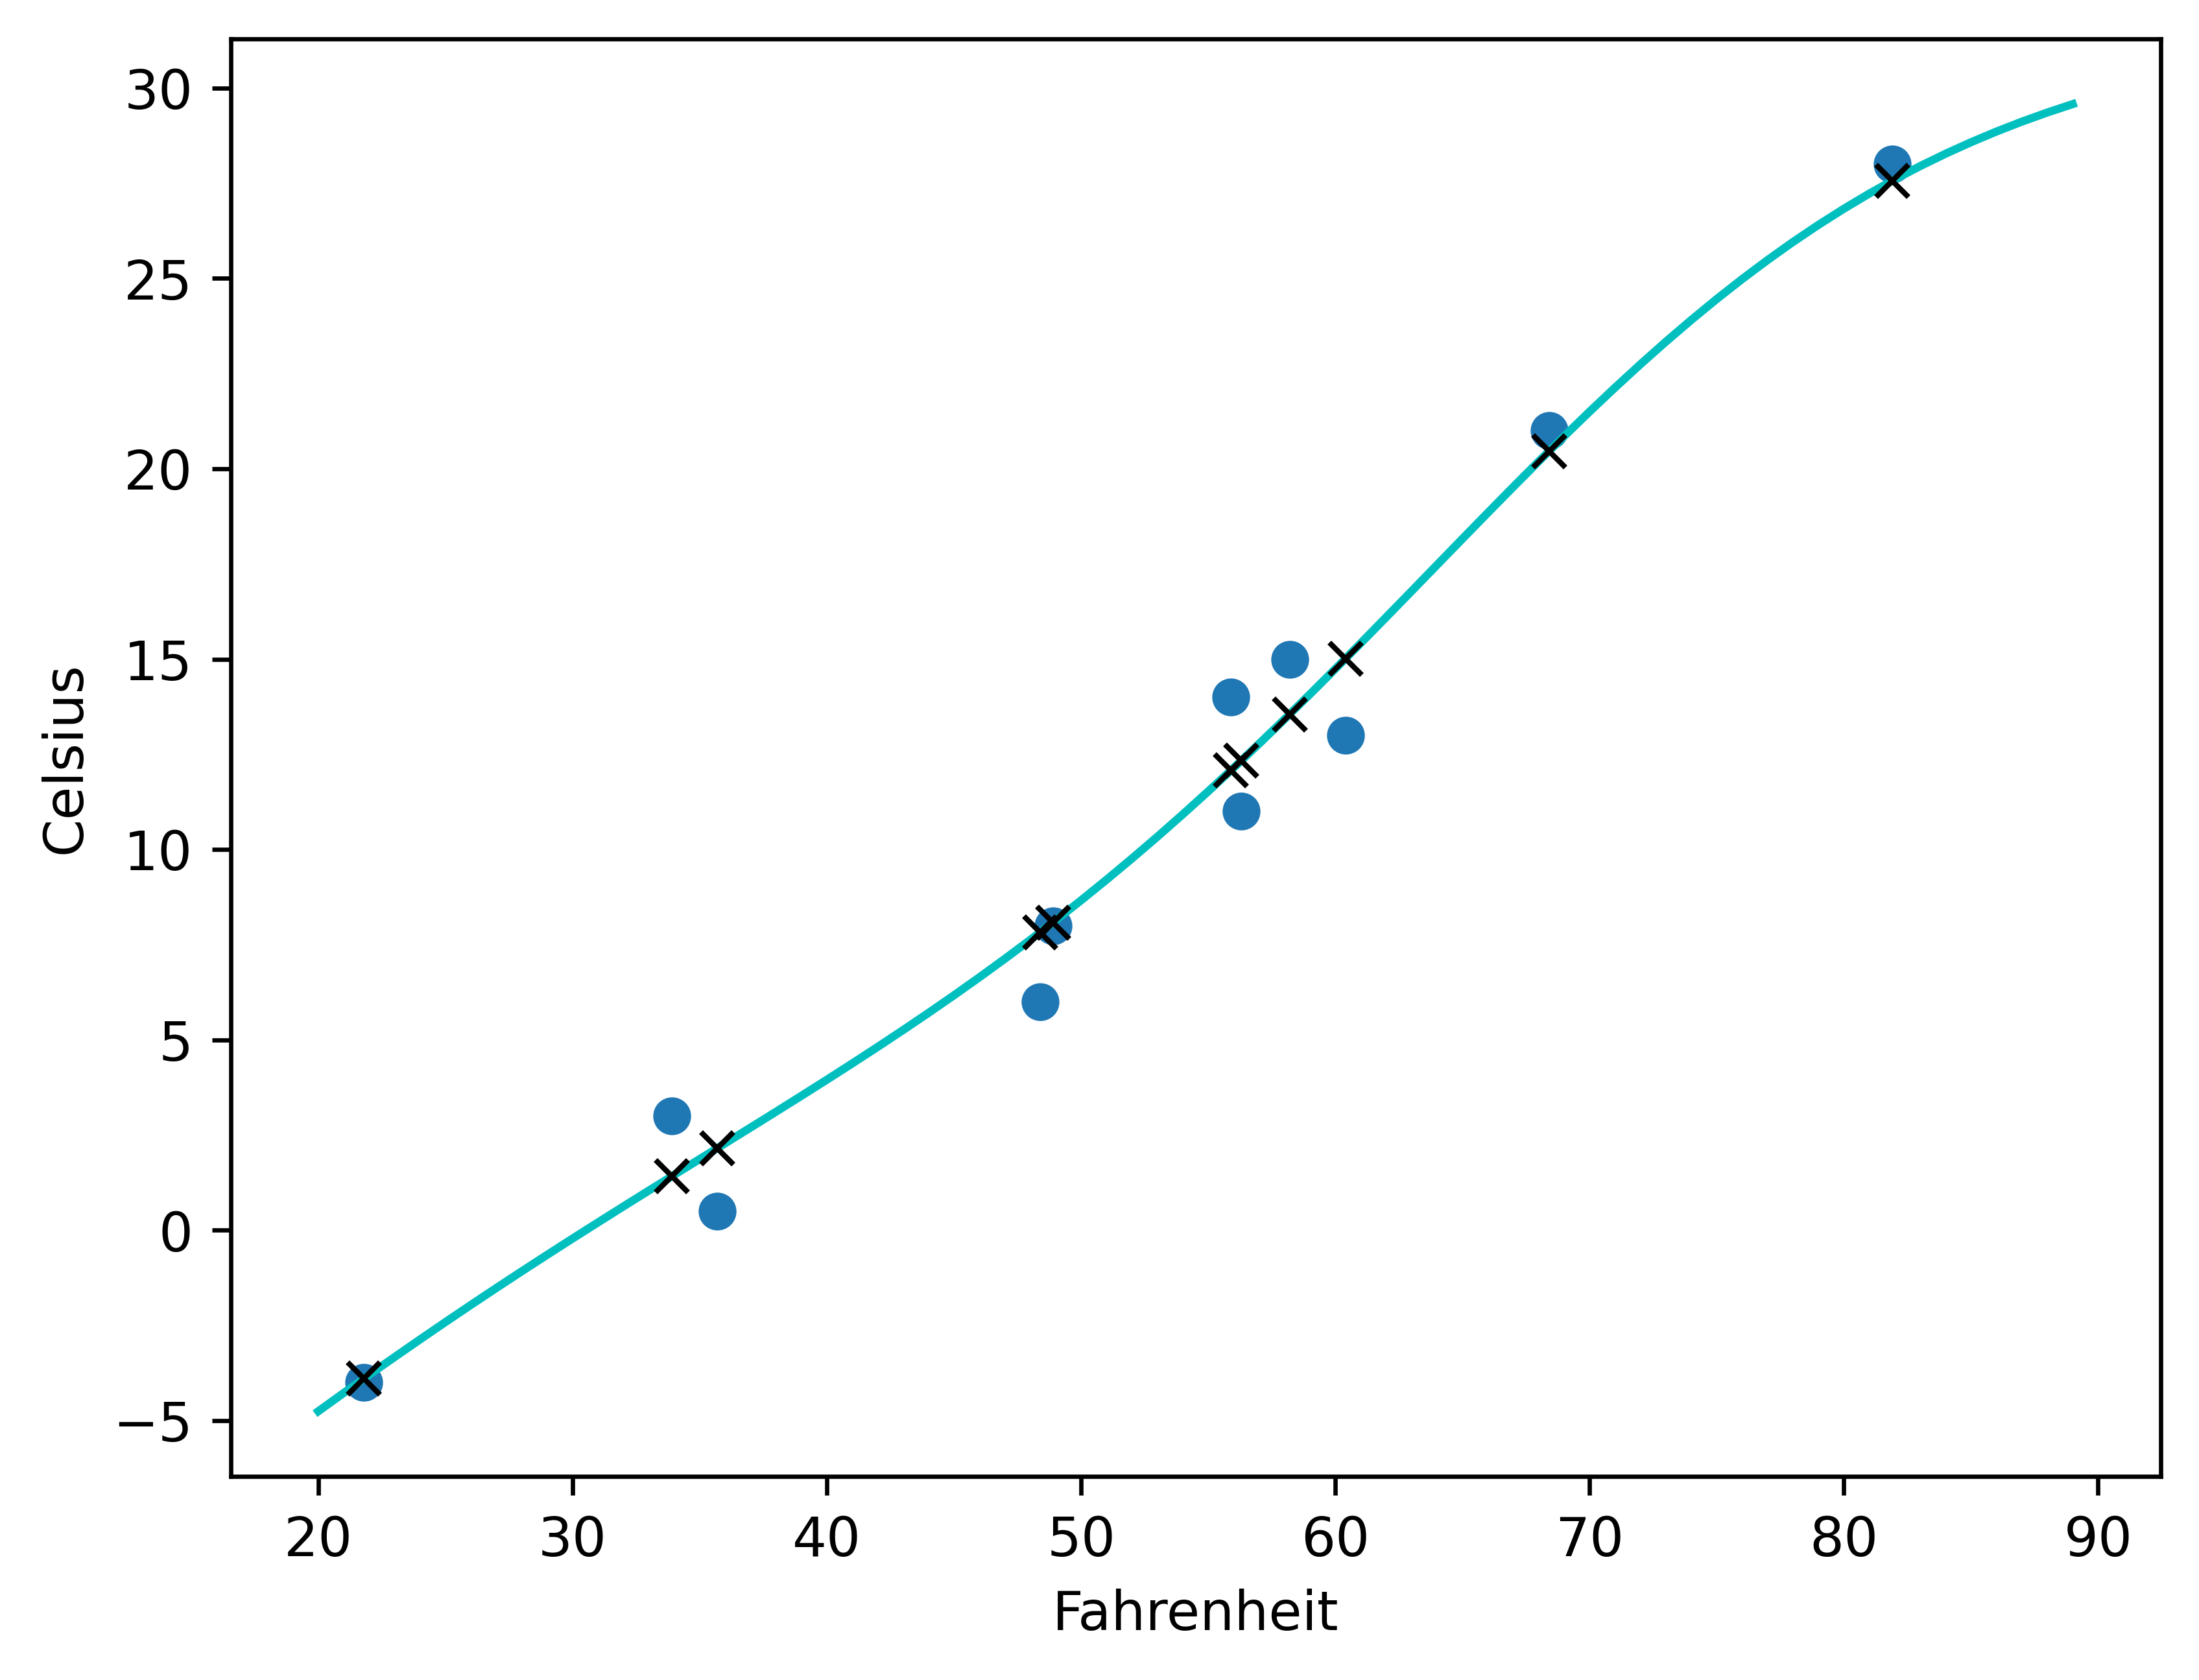

In [26]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 172.7123, Validation loss 233.8854
Epoch 1000, Training loss 52.3367, Validation loss 53.9068
Epoch 2000, Training loss 29.6152, Validation loss 34.4662
Epoch 3000, Training loss 16.6923, Validation loss 21.8694
Epoch 4000, Training loss 10.1860, Validation loss 14.5756
Epoch 5000, Training loss 7.2451, Validation loss 10.5197


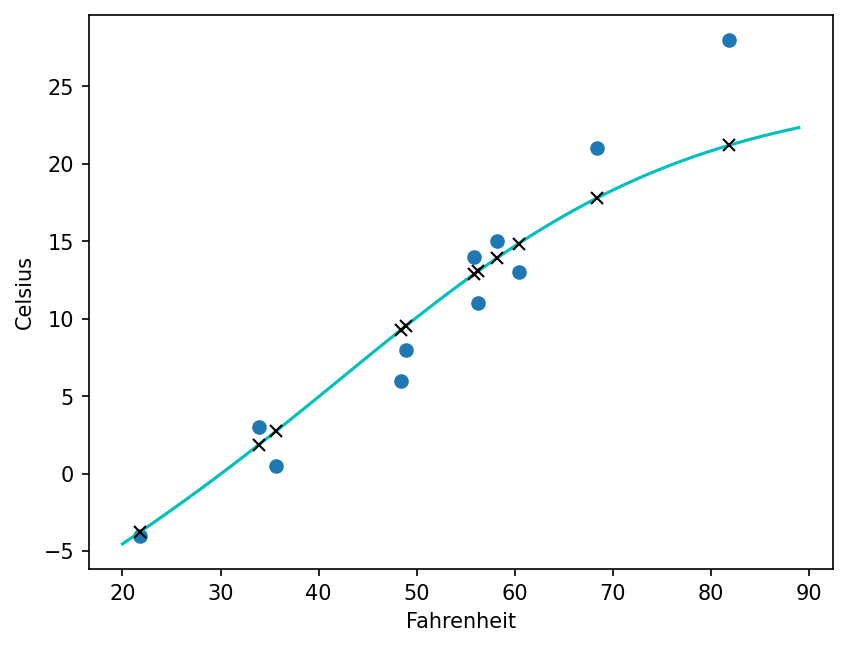

In [27]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
